# Video Summarizer 모델 학습/평가 코드

In [32]:
import os
import math
import numpy as np
import pandas as pd

## 경로 설정

In [2]:
# dataset_dir = r'E:\Work\YasuoNet\data\dataset14_sl3_vsr2_vw64_vh64_asr22050_mfcc'
dataset_dir = r'E:\Work\YasuoNet\data\dataset120_sl3_vsr2_vw64_vh64_asr22050_mfcc'
ckpt_dir = 'checkpoints'

## 하이퍼파라미터 설정

In [3]:
learning_rate = 1e-4
epochs = 200
batch_size = 256
class_weights = (1, 1)
x_includes = ['video', 'audio']

# for basic model
x_expand = 0
# for sequence model
# x_expand = 2    # 앞 2개, 뒤 2개 segment 포함

## 데이터 로더 생성

In [4]:
from data_loader import DataLoader

data_loader = DataLoader(dataset_dir, x_includes=x_includes, x_expand=x_expand)

data_config = data_loader.get_metadata()['config']
input_shape_dict = data_loader.get_metadata()['data_shape']

## 모델 생성

In [91]:
from tensorflow.keras.layers import Dense, Dropout, Conv3D, Conv2D, Input, MaxPool3D, MaxPool2D, Flatten, concatenate, Reshape
from tensorflow.keras.layers import TimeDistributed, LSTM
from tensorflow.keras.backend import expand_dims
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.utils import plot_model

def build_basic_model():
    video_input_shape = input_shape_dict['video']
    audio_input_shape = input_shape_dict['audio']
    weight_decay = 0.005

    # Video 3D Conv layers
    video_input = Input(video_input_shape, name='video_input')
    x = video_input
    x = Conv3D(8, (3, 3, 3), strides=(1, 1, 1), padding='same', activation='relu', kernel_initializer='he_uniform', kernel_regularizer=l2(weight_decay))(x)
    x = MaxPool3D((2, 2, 2), strides=(2, 2, 2), padding='same')(x)
    video_output = Flatten(name='video_output')(x)
    
    video_model = Model(inputs=video_input, outputs=video_output)

    # Audio 2D Conv layers
    audio_input = Input(audio_input_shape, name='audio_input')
    x = Reshape(audio_input_shape + [1])(audio_input)    # add channel dim
    x = Conv2D(4, (3, 3), strides=(1, 1), padding='same', activation='relu', kernel_initializer='he_uniform', kernel_regularizer=l2(weight_decay))(x)
    x = MaxPool2D((2, 2), strides=(2, 2), padding='same')(x)
    audio_output = Flatten(name='audio_output')(x)
    
    audio_model = Model(inputs=audio_input, outputs=audio_output)
    
    # Make video/audio combined model for saving after train
    combined_output = concatenate([video_output, audio_output])
    
    combined_model = Model(inputs=[video_input, audio_input], outputs=combined_output)

    # Fully-connected layers
    x = combined_output
    x = Dense(16, activation='relu', kernel_initializer='he_uniform', kernel_regularizer=l2(weight_decay))(x)
    fc_output = Dense(1, activation='sigmoid', kernel_initializer='he_uniform', kernel_regularizer=l2(weight_decay))(x)

    # Make entire model for training
    entire_model = Model(inputs=[video_input, audio_input], outputs=fc_output)

    return video_model, audio_model, combined_model, entire_model

def build_sequence_model():
    video_input_shape = [None] + input_shape_dict['video']
    audio_input_shape = [None] + input_shape_dict['audio']
    weight_decay = 0.005

    # Video 3D Conv layers
    video_input = Input(video_input_shape)
    x = video_input
    x = TimeDistributed(Conv3D(8, (3, 3, 3), strides=(1, 1, 1), padding='same', activation='relu', kernel_initializer='he_uniform', kernel_regularizer=l2(weight_decay)))(x)
    x = TimeDistributed(MaxPool3D((2, 2, 2), strides=(2, 2, 2), padding='same'))(x)
    video_output = TimeDistributed(Flatten())(x)
    
    # Audio 2D Conv layers
    audio_input = Input(audio_input_shape)
    x = Reshape(audio_input_shape + [1])(audio_input)    # add channel dim
    x = TimeDistributed(Conv2D(4, (3, 3), strides=(1, 1), padding='same', activation='relu', kernel_initializer='he_uniform', kernel_regularizer=l2(weight_decay)))(x)
    x = TimeDistributed(MaxPool2D((2, 2), strides=(2, 2), padding='same'))(x)
    audio_output = TimeDistributed(Flatten())(x)
    
    # LSTM layers
    x = concatenate([video_output, audio_output])
    x = LSTM(16, activation='relu', kernel_initializer='he_uniform', kernel_regularizer=l2(weight_decay))(x)

    # Fully-connected layers
    x = Dense(16, activation='relu', kernel_initializer='he_uniform', kernel_regularizer=l2(weight_decay))(x)
    #     x = Dropout(0.2)(x)
    fc_output = Dense(1, activation='sigmoid', kernel_initializer='he_uniform', kernel_regularizer=l2(weight_decay))(x)

    model = Model(inputs=[video_input, audio_input], outputs=fc_output)

    return model

def build_sequence_model_with_pretrained(checkpoint_name):
    video_input_shape = input_shape_dict['video']
    audio_input_shape = input_shape_dict['audio']
    video_seq_input_shape = [None] + video_input_shape
    audio_seq_input_shape = [None] + audio_input_shape
    weight_decay = 0.005

    # Load pretrained models
    saved_model_name = checkpoint_name + '_model'
    video_model_name = saved_model_name + '_video'
    audio_model_name = saved_model_name + '_audio'
    video_model_path = os.path.join(ckpt_dir, video_model_name + '.h5')
    audio_model_path = os.path.join(ckpt_dir, audio_model_name + '.h5')

    video_model = load_model(video_model_path)
    audio_model = load_model(audio_model_path)
    video_model.trainable = audio_model.trainable = False

    # Input layers
    video_seq_input = Input(video_seq_input_shape)
    audio_seq_input = Input(audio_seq_input_shape)

    # Combine video/audio layers
    video_seq_output = TimeDistributed(video_model)(video_seq_input)
    audio_seq_output = TimeDistributed(audio_model)(audio_seq_input)
    combined_seq_output = concatenate([video_seq_output, audio_seq_output])
    
    # LSTM layers
    x = combined_seq_output
    x = LSTM(32, activation='relu', kernel_initializer='he_uniform', kernel_regularizer=l2(weight_decay))(x)

    # Fully-connected layers
    x = Dense(32, activation='relu', kernel_initializer='he_uniform', kernel_regularizer=l2(weight_decay))(x)
    #     x = Dropout(0.2)(x)
    fc_output = Dense(1, activation='sigmoid', kernel_initializer='he_uniform', kernel_regularizer=l2(weight_decay))(x)

    model = Model(inputs=[video_seq_input, audio_seq_input], outputs=fc_output)

    return model

Model: "model_15"
________________________________________________________________________________________________________________________________________
Layer (type)                                Output Shape                  Param #          Connected to                                 
audio_input (InputLayer)                    [(None, 40, 130)]             0                                                             
________________________________________________________________________________________________________________________________________
video_input (InputLayer)                    [(None, 6, 64, 64, 3)]        0                                                             
________________________________________________________________________________________________________________________________________
reshape_2 (Reshape)                         (None, 40, 130, 1)            0                audio_input[0][0]                            
_______________________

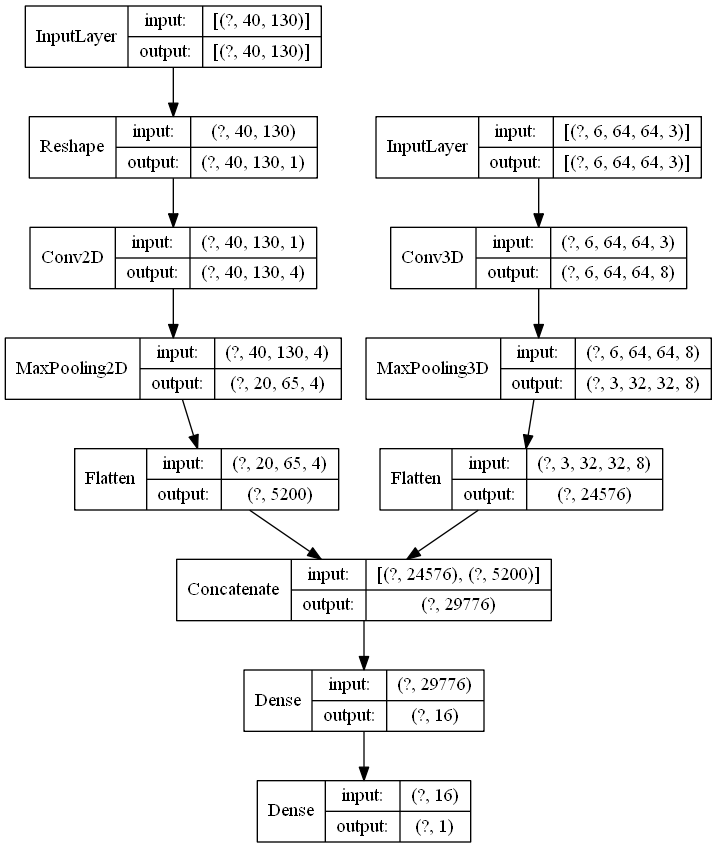

In [95]:
# for basic model
video_model, audio_model, combined_model, model = build_basic_model()
# for sequence model
# model = build_sequence_model()
# for sequence model with pretrained combined model
# model = build_sequence_model_with_pretrained('ckpt-20200825-163656-0002-0.3130-0.4588')

model.summary(line_length=136)
plot_model(model, show_shapes=True, show_layer_names=False)

## 모델 학습

In [28]:
from trainer import Trainer
from tensorflow.keras.optimizers import Adam

# 학습 시작
trainer = Trainer(model, data_loader, ckpt_dir)
trainer.train(Adam(learning_rate), epochs, batch_size, class_weights)

Training started at 20200825-161855
optimizer: {'name': 'Adam', 'learning_rate': 0.0001, 'decay': 0.0, 'beta_1': 0.9, 'beta_2': 0.999, 'epsilon': 1e-07, 'amsgrad': False}
epochs: 200
batch size: 256
class weights: (1, 1)
normalized class weights: [1. 1.]




Train stopped

Top5 models


KeyError: "None of ['epoch'] are in the columns"

##  가중치 복원
모델이 선언되어 있을 때 저장된 가중치를 복원

In [7]:
checkpoint_name = 'ckpt-20200823-222735-0020-0.6650'
model.load_weights(os.path.join(ckpt_dir, checkpoint_name + '.h5'))

## 모델 테스트

In [8]:
from sklearn.metrics import confusion_matrix, classification_report
from trainer import Trainer

trainer = Trainer(model, data_loader, ckpt_dir)
y_true, y_pred = trainer.test_prediction(batch_size)

print(f'test data count: {len(y_true)}')
print(f'true_1, pred_1: {y_true.sum(), y_pred.sum()}')
print()
print('Confusion Matrix:')
print(confusion_matrix(y_true, y_pred))
print()
print('Report:')
print(classification_report(y_true, y_pred))


test data count: 33094
true_1, pred_1: (3585, 3665)

Confusion Matrix:
[[28210  1299]
 [ 1219  2366]]

Report:
              precision    recall  f1-score   support

           0       0.96      0.96      0.96     29509
           1       0.65      0.66      0.65      3585

    accuracy                           0.92     33094
   macro avg       0.80      0.81      0.80     33094
weighted avg       0.92      0.92      0.92     33094



## 모델의 모든 정보를 온전하게 저장 / 복원
모델의 가중치 뿐만아니라 모든 레이어 구성 정보를 저장하여 추후 모델 선언부가 없어도 불러와서 사용 가능

### 모델 저장

In [12]:
checkpoint_name = 'ckpt-20200823-222735-0020-0.6650-0.6527'
model_name = checkpoint_name + '_model'
model_path = os.path.join(ckpt_dir, model_name + '.h5')
print(model_path)

video_model_name = model_name + '_video'
audio_model_name = model_name + '_audio'
combined_model_name = model_name + '_combined'
video_model_path = os.path.join(ckpt_dir, video_model_name + '.h5')
audio_model_path = os.path.join(ckpt_dir, audio_model_name + '.h5')
combined_model_path = os.path.join(ckpt_dir, combined_model_name + '.h5')
print(video_model_path)
print(audio_model_path)
print(combined_model_path)

checkpoints\ckpt-20200823-222735-0020-0.6650-0.6527_model.h5
checkpoints\ckpt-20200823-222735-0020-0.6650-0.6527_model_video.h5
checkpoints\ckpt-20200823-222735-0020-0.6650-0.6527_model_audio.h5
checkpoints\ckpt-20200823-222735-0020-0.6650-0.6527_model_combined.h5


In [13]:
model.save(model_path)

video_model.save(video_model_path)
audio_model.save(audio_model_path)
combined_model.save(combined_model_path)

### 모델 복원

In [14]:
checkpoint_name = 'ckpt-20200823-222735-0020-0.6650-0.6527'
model_name = checkpoint_name + '_model'
model_path = os.path.join(ckpt_dir, model_name + '.h5')
print(model_path)

checkpoints\ckpt-20200823-222735-0020-0.6650-0.6527_model.h5


In [15]:
from tensorflow.keras.models import load_model

model_restored = load_model(model_path)

In [16]:
model_restored.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 40, 130)]    0                                            
__________________________________________________________________________________________________
input_1 (InputLayer)            [(None, 6, 64, 64, 3 0                                            
__________________________________________________________________________________________________
tf_op_layer_ExpandDims (TensorF (None, 40, 130, 1)   0           input_2[0][0]                    
__________________________________________________________________________________________________
conv3d (Conv3D)                 (None, 6, 64, 64, 16 1312        input_1[0][0]                    
____________________________________________________________________________________________

### 복원된 모델 테스트

In [17]:
from sklearn.metrics import confusion_matrix, classification_report
from trainer import Trainer

trainer = Trainer(model_restored, data_loader, ckpt_dir)
y_true, y_pred = trainer.test_prediction(batch_size)

print(f'test data count: {len(y_true)}')
print(f'true_1, pred_1: {y_true.sum(), y_pred.sum()}')
print()
print('Confusion Matrix:')
print(confusion_matrix(y_true, y_pred))
print()
print('Report:')
print(classification_report(y_true, y_pred))


test data count: 33094
true_1, pred_1: (3585, 3665)

Confusion Matrix:
[[28210  1299]
 [ 1219  2366]]

Report:
              precision    recall  f1-score   support

           0       0.96      0.96      0.96     29509
           1       0.65      0.66      0.65      3585

    accuracy                           0.92     33094
   macro avg       0.80      0.81      0.80     33094
weighted avg       0.92      0.92      0.92     33094



## 예측값을 그래프로 확인
모델 테스트 실행하여 y_true, y_pred 변수에 값이 있을 때 실행

In [89]:
import matplotlib.pyplot as plt

def plot_predictions():
    segment_length = data_loader.get_metadata()['config']['segment_length']
    
    segment_df = data_loader.test_segment_df.copy()
    segment_df['pred'] = y_pred
    
    title_list = sorted(segment_df['title'].unique())
    fig, axes = plt.subplots(len(title_list), 1, figsize=(16, 2 * len(title_list)))
    
    for i, title in enumerate(title_list):
        title_segment_df = segment_df[segment_df['title'] == title].sort_values(by='index')
        labels = title_segment_df['label'].values
        preds = title_segment_df['pred'].values
        
        axes[i].plot(labels, label='Label')
        axes[i].plot(preds * .95, label='Prediction')
        axes[i].set_title(title)
        axes[i].legend()
        
    fig.tight_layout()

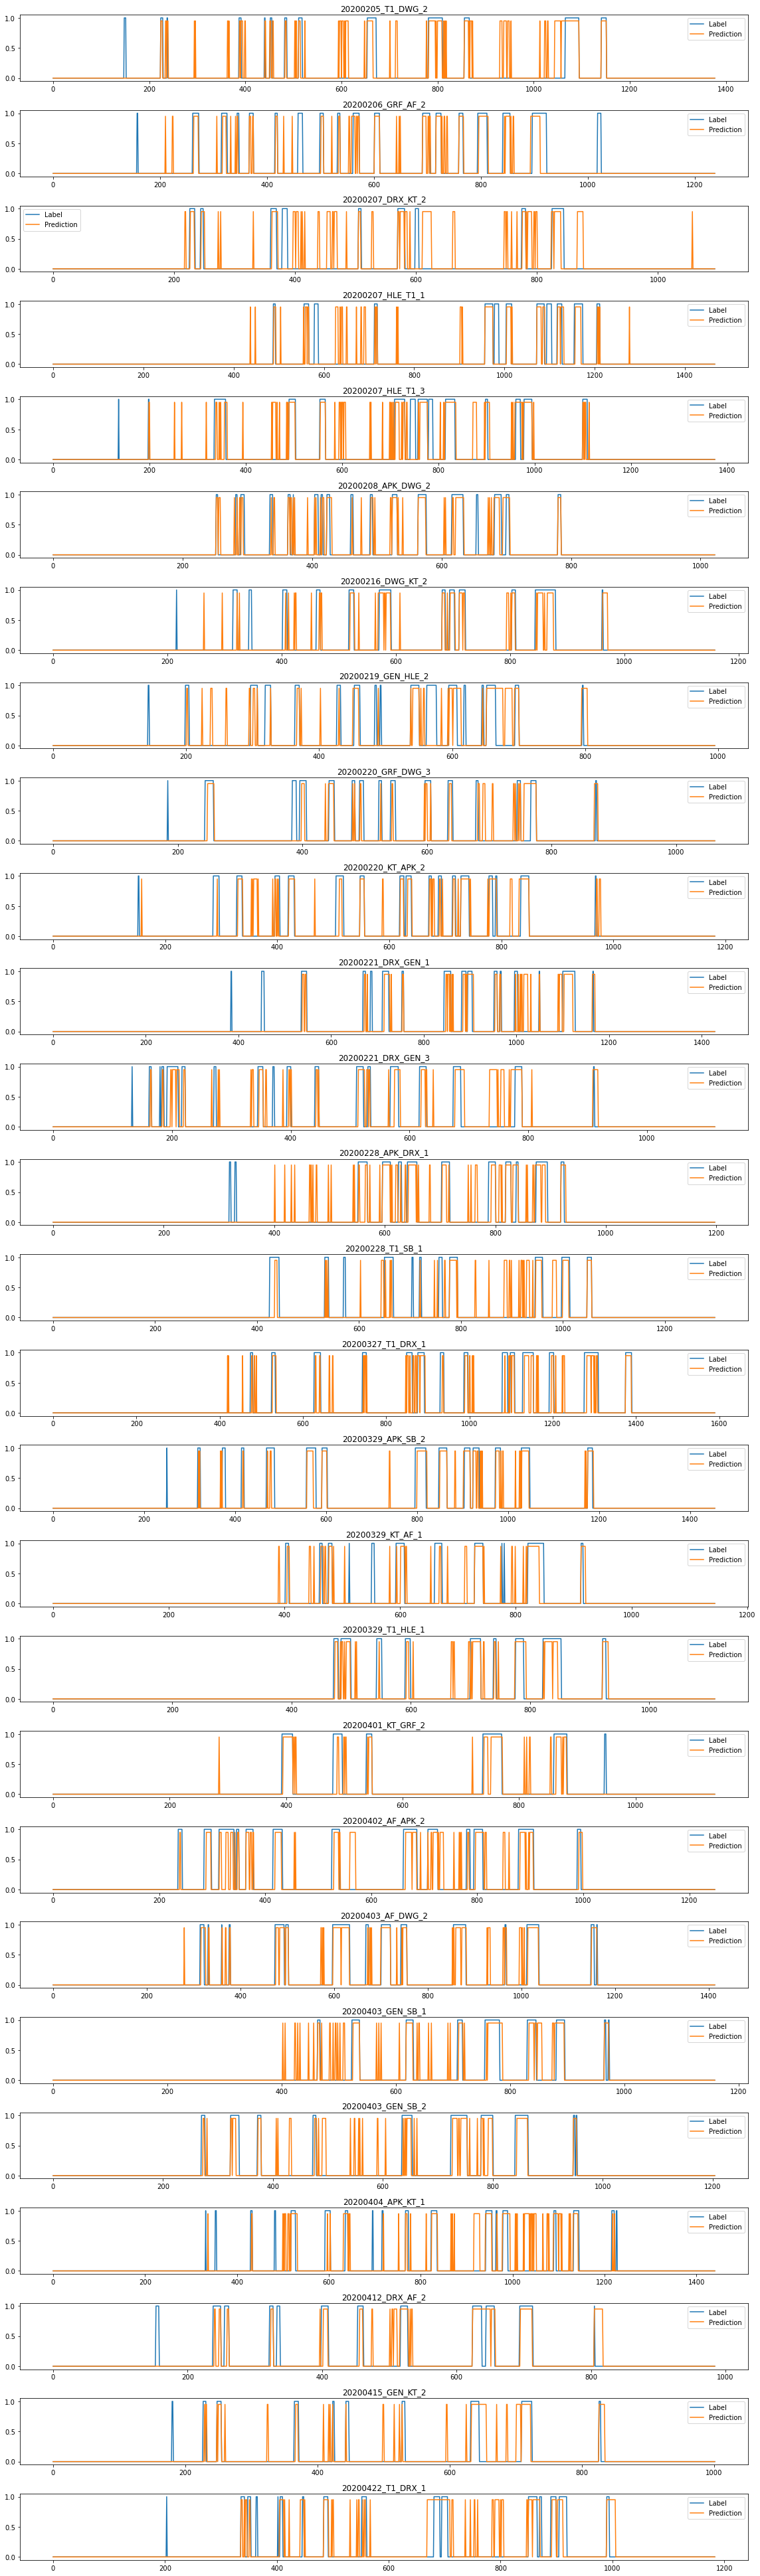

In [90]:
plot_predictions()

## 예측 틀린 부분 찾기
특정 영상의 제목을 입력하면 예측이 틀린 부분을 표시

In [116]:
def print_false_predictions(title):
    from data_converter import to_hms
    
    pd.set_option('display.max_rows', None)
    
    segment_length = data_loader.get_metadata()['config']['segment_length']
    
    segment_df = data_loader.test_segment_df.copy()
    segment_df['pred'] = y_pred
    title_segment_df = segment_df[segment_df['title'] == title].sort_values(by='index')
    
    title_segment_df['time'] = (title_segment_df['index'] * segment_length).apply(to_hms)
    
    columns = ['title', 'index', 'time', 'label', 'pred']
    print(title_segment_df[title_segment_df['label'] != title_segment_df['pred']][columns])

In [117]:
# 확인하고 싶은 영상 제목을 입력
print_false_predictions('20200205_T1_DWG_2')

                  title  index      time  label  pred
3510  20200205_T1_DWG_2    148  00:07:24      1     0
3511  20200205_T1_DWG_2    149  00:07:27      1     0
3512  20200205_T1_DWG_2    150  00:07:30      1     0
3513  20200205_T1_DWG_2    151  00:07:33      1     0
3590  20200205_T1_DWG_2    228  00:11:24      1     0
3596  20200205_T1_DWG_2    234  00:11:42      0     1
3597  20200205_T1_DWG_2    235  00:11:45      0     1
3601  20200205_T1_DWG_2    239  00:11:57      0     1
3656  20200205_T1_DWG_2    294  00:14:42      0     1
3658  20200205_T1_DWG_2    296  00:14:48      0     1
3725  20200205_T1_DWG_2    363  00:18:09      0     1
3726  20200205_T1_DWG_2    364  00:18:12      0     1
3728  20200205_T1_DWG_2    366  00:18:18      0     1
3749  20200205_T1_DWG_2    387  00:19:21      1     0
3752  20200205_T1_DWG_2    390  00:19:30      1     0
3754  20200205_T1_DWG_2    392  00:19:36      0     1
3755  20200205_T1_DWG_2    393  00:19:39      0     1
3756  20200205_T1_DWG_2    3

## 예측값 파일에 기록하기

In [134]:
def save_predictions():
    from data_converter import to_hms
    
    segment_length = data_loader.get_metadata()['config']['segment_length']
    
    segment_df = data_loader.test_segment_df.copy()
    segment_df['pred'] = y_pred
    segment_df['start_sec'] = (segment_df['index'] * segment_length)
    segment_df['end_sec'] = ((segment_df['index'] + 1) * segment_length)
    segment_df['start_time'] = segment_df['start_sec'].apply(to_hms)
    segment_df['end_time'] = segment_df['end_sec'].apply(to_hms)
    segment_df['start_frame'] = (segment_df['start_sec'] * 29.97).astype(np.int32)
    segment_df['end_frame'] = (segment_df['end_sec'] * 29.97 - 1).astype(np.int32)
    
    title_list = sorted(segment_df['title'].unique())
    
    for i, title in enumerate(title_list):
        title_segment_df = segment_df[segment_df['title'] == title].sort_values(by='index')
        
        columns = ['index', 'start_sec', 'end_sec', 'start_time', 'end_time', 'start_frame', 'end_frame', 'label', 'pred']
        title_segment_df.to_csv(title + '.csv', columns=columns, index=False)

In [135]:
save_predictions()